### WELCOME
This notebook displays Stava stats for the current year

In [7]:
import keys
print(keys.refresh_token)

86766950ab79c4214a568aa32a7cff5d3f89b71a


In [1]:
## Connect to data and load all activities
## Don't be alarmed if this code segment takes some time to run
import requests
import urllib3
import keys
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': keys.a,
    'client_secret': keys.b,
    'refresh_token': keys.c,
    'grant_type': "refresh_token",
    'f': 'json'
}

#print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
#print("Access Token = {}\n".format(access_token))

header = {'Authorization': 'Bearer ' + access_token}
param = {'per_page': 200, 'page': 1}
my_dataset = requests.get(activites_url, headers=header, params=param).json()

request_page_num = 1
all_activities = []
load = False

while True:
    param = {'per_page': 200, 'page': request_page_num}
    # initial request, where we request the first page of activities
    my_dataset = requests.get(activites_url, headers=header, params=param).json()

    # check the response to make sure it is not empty. If it is empty, that means there is no more data left. So if you have
    # 1000 activities, on the 6th request, where we request page 6, there would be no more data left, so we will break out of the loop
    if len(my_dataset) == 0:
        #print("breaking out of while loop because the response is zero, which means there must be no more activities")
        if load:
            print("Successfully loaded all data")
        else:
            print("No data found, an error occured :\(")
        break

    # if the all_activities list is already populated, that means we want to add additional data to it via extend.
    if all_activities:
        # print("all_activities_map is populated")
        all_activities.extend(my_dataset)

    # if the all_activities is empty, this is the first time adding data so we just set it equal to my_dataset
    else:
        # print("all_activities is NOT populated")
        all_activities = my_dataset
        load = True

    request_page_num += 1


Successfully loaded all data


In [2]:
## loads data and updates columns to correct units
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

activities = pd.json_normalize(all_activities)

#Create new dataframe with only columns I care about
cols = ['name', 'upload_id', 'type', 'distance', 'moving_time',   
         'average_speed', 'max_speed','total_elevation_gain',
         'start_date_local'
       ]
activities = activities[cols]
#Break date into start time and date
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'], errors='coerce')
activities['start_time'] = activities['start_date_local'].dt.time
#activities['start_date_local'] = activities['start_date_local'].dt.date
# change time to minutes
activities['moving_time'] = activities['moving_time'] / 60
# change to mph for biking and minute mile for running
def update_speed(row):
    if row['type'] == 'Ride':
        return row['average_speed'] * 2.23697
    else:
        if row['average_speed'] == 0:
            return 0
        else:
            return 26.8224 / row['average_speed'] 
activities['avg_pace'] = activities.apply(update_speed, axis=1)
# change distance to miles
activities['distance'] = activities['distance'] / 1609


Running totals by Week & Month

                            distance
start_date_local                    
2024-03-24 00:00:00+00:00  35.560472
2024-09-08 00:00:00+00:00  35.333686
2023-01-15 00:00:00+00:00  35.239466
2024-08-25 00:00:00+00:00  35.138098
2024-08-18 00:00:00+00:00  35.081231
2023-01-22 00:00:00+00:00  35.077191
2023-02-12 00:00:00+00:00  35.054319
2023-03-12 00:00:00+00:00  35.052082
2024-04-14 00:00:00+00:00  34.616781
2024-01-28 00:00:00+00:00  34.118272


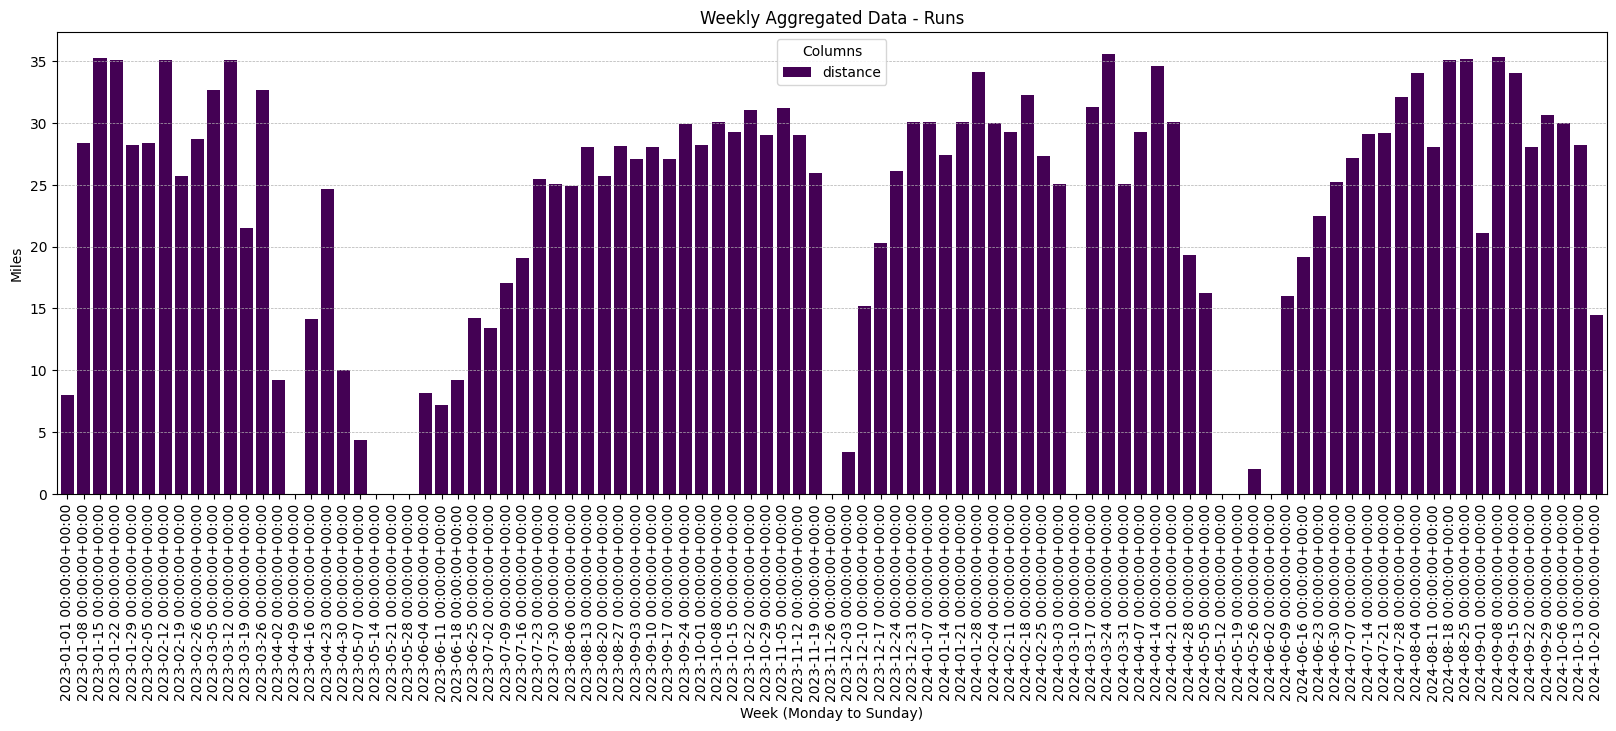

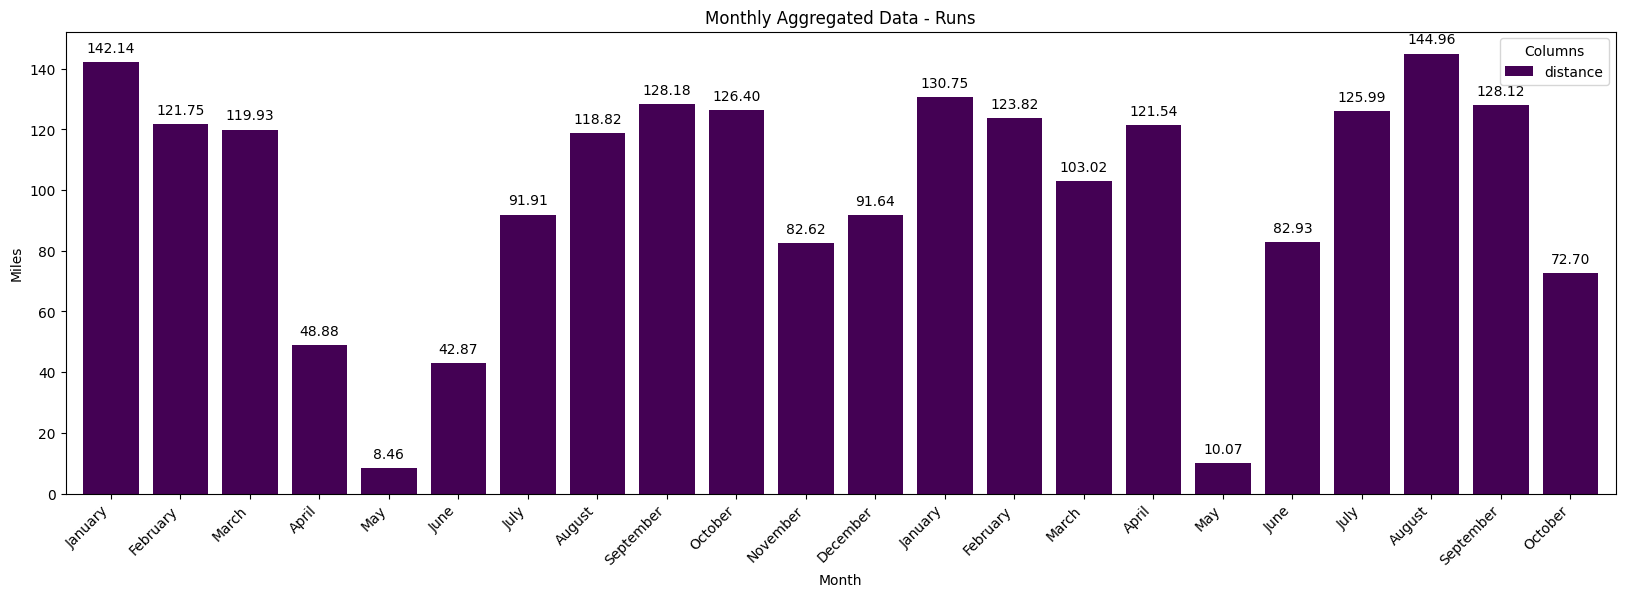

In [3]:
## Running totals by Week & Month
runs = activities.loc[(activities['type'] == 'Run')  & (activities['distance'] >= .2) & (activities['start_date_local'] > '2023-01-01')]

# pace vs distance
#sns.set(style="ticks", context="talk")
#sns.regplot(x='distance', y = 'avg_pace', data = runs).set_title("Average Pace vs Distance")

# miles per week
runs_byweek = runs[['distance', 'start_date_local']] #['distance', 'avg_pace', 'moving_time', 'start_date_local']
aggregations = {
    'distance': 'sum',   # Sum the 'distance' column
    #'moving_time': 'sum',   # Sum the 'duration' column
    #'avg_pace': 'mean',     # Average the 'speed' column
}

# Group by week (Monday to Sunday) and apply aggregations
runs_byweek = runs_byweek.resample('W-Sun', on='start_date_local').agg(aggregations)

top10 = runs_byweek.nlargest(10, 'distance')
print(top10)

# Display the result
ax = runs_byweek.plot(kind='bar', figsize=(20, 6), width=0.8, colormap='viridis')

plt.title('Weekly Aggregated Data - Runs')
plt.xlabel('Week (Monday to Sunday)')
plt.ylabel('Miles')
plt.grid(axis = 'y',linestyle = '--', linewidth = 0.5)
plt.legend(title='Columns')

plt.show()

# miles per month
runs_bymonth = runs[['distance', 'start_date_local']] #['distance', 'avg_pace', 'moving_time', 'start_date_local']
aggregations = {
    'distance': 'sum',   # Sum the 'distance' column
    # 'moving_time': 'sum',   # Sum the 'duration' column
    #'avg_pace': 'mean',     # Average the 'speed' column
}

# Group by week (Monday to Sunday) and apply aggregations
runs_bymonth = runs_bymonth.resample('M', on='start_date_local').agg(aggregations)

# Display the result
ax = runs_bymonth.plot(kind='bar', figsize=(20, 6), width=0.8, colormap='viridis')
ax.set_xticklabels(runs_bymonth.index.strftime('%B'), rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.title('Monthly Aggregated Data - Runs')
plt.xlabel('Month')
plt.ylabel('Miles')
plt.legend(title='Columns')
plt.show()


Biking totals by Week & Month

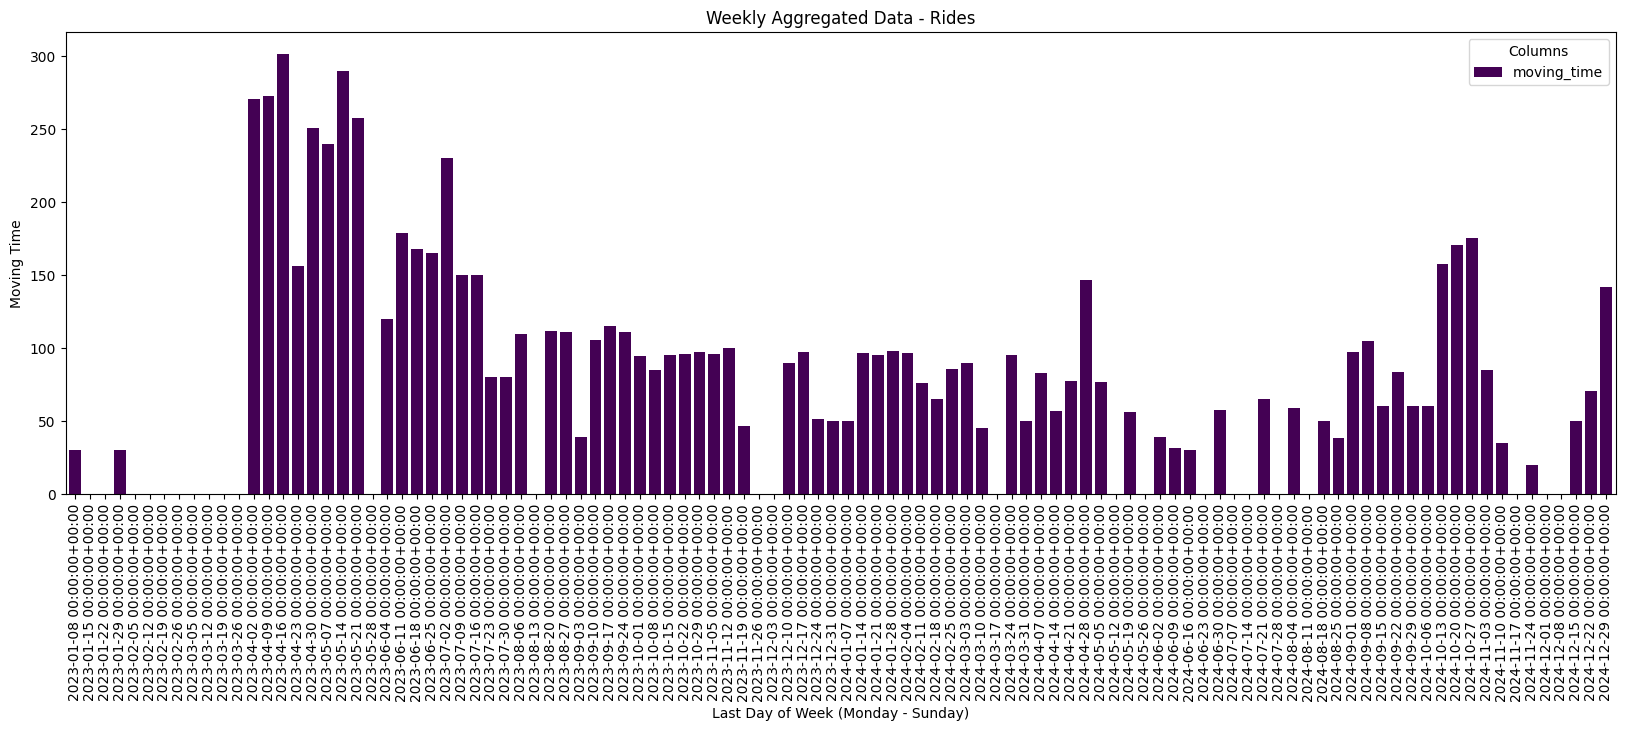

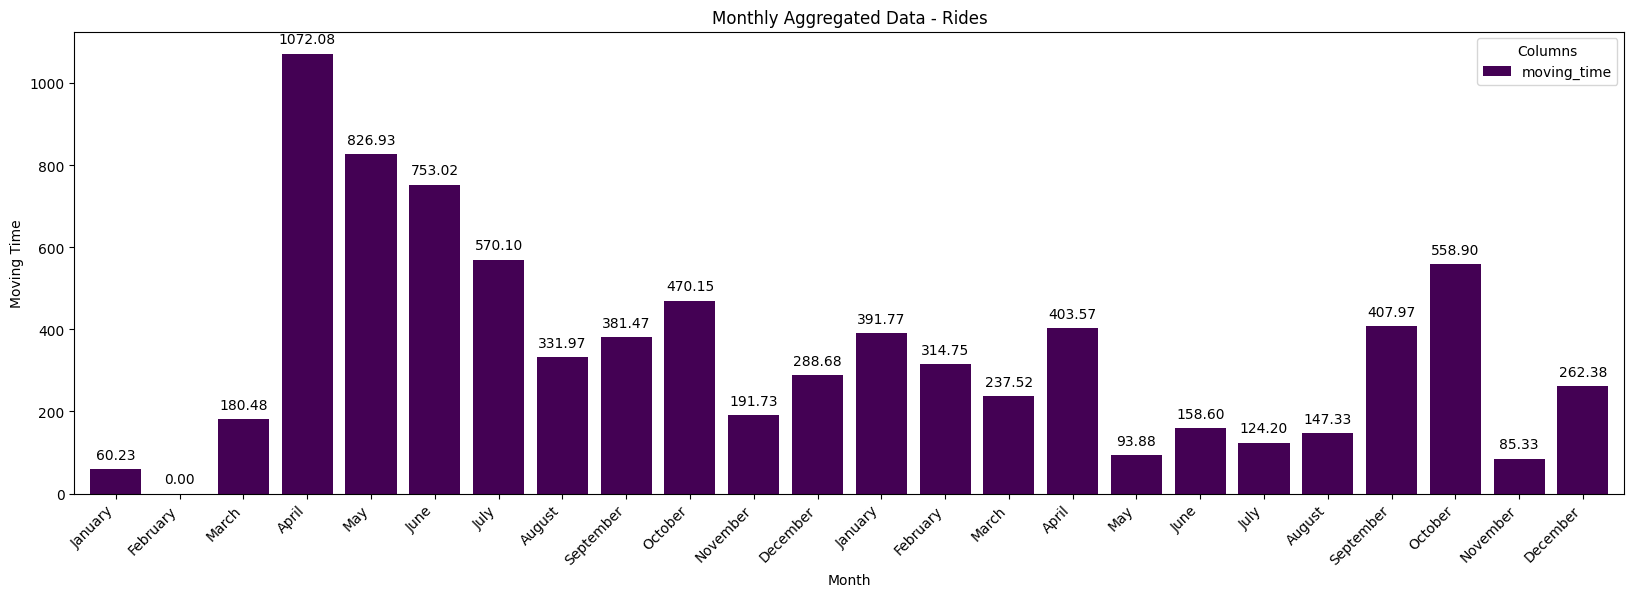

In [13]:
## Biking total by week and month
bikes = activities.loc[(activities['type'] == 'Ride')  & (activities['start_date_local'] > '2023-01-01')]  #& (activities['distance'] >= .5) 

# pace vs distance
#sns.set(style="ticks", context="talk")
#sns.regplot(x='distance', y = 'avg_pace', data = runs).set_title("Average Pace vs Distance")

# miles per week
bikes_byweek = bikes[['moving_time', 'start_date_local']] #['distance', 'avg_pace', 'moving_time', 'start_date_local']
aggregations = {
    # 'distance': 'sum',   # Sum the 'distance' column
    'moving_time': 'sum',   # Sum the 'duration' column
    #'avg_pace': 'mean',     # Average the 'speed' column
}

# Group by week and apply aggregations
bikes_byweek = bikes_byweek.resample('W-Sun', on='start_date_local').agg(aggregations)

# Display the result
ax = bikes_byweek.plot(kind='bar', figsize=(20, 6), width=0.8, colormap='viridis')
plt.title('Weekly Aggregated Data - Rides')
plt.xlabel('Last Day of Week (Monday - Sunday)')
plt.ylabel('Moving Time')
plt.legend(title='Columns')
plt.show()

# miles per month
bikes_bymonth = bikes[['moving_time', 'start_date_local']] #['distance', 'avg_pace', 'moving_time', 'start_date_local']
aggregations = {
    #'distance': 'sum',   # Sum the 'distance' column
    'moving_time': 'sum',   # Sum the 'duration' column
    #'avg_pace': 'mean',     # Average the 'speed' column
}

# Group by week (Monday to Sunday) and apply aggregations
bikes_bymonth = bikes_bymonth.resample('M', on='start_date_local').agg(aggregations)

# Display the result
ax = bikes_bymonth.plot(kind='bar', figsize=(20, 6), width=0.8, colormap='viridis')
ax.set_xticklabels(bikes_bymonth.index.strftime('%B'), rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.title('Monthly Aggregated Data - Rides')
plt.xlabel('Month')
plt.ylabel('Moving Time')
plt.legend(title='Columns')
plt.show()

# Swimming Totals

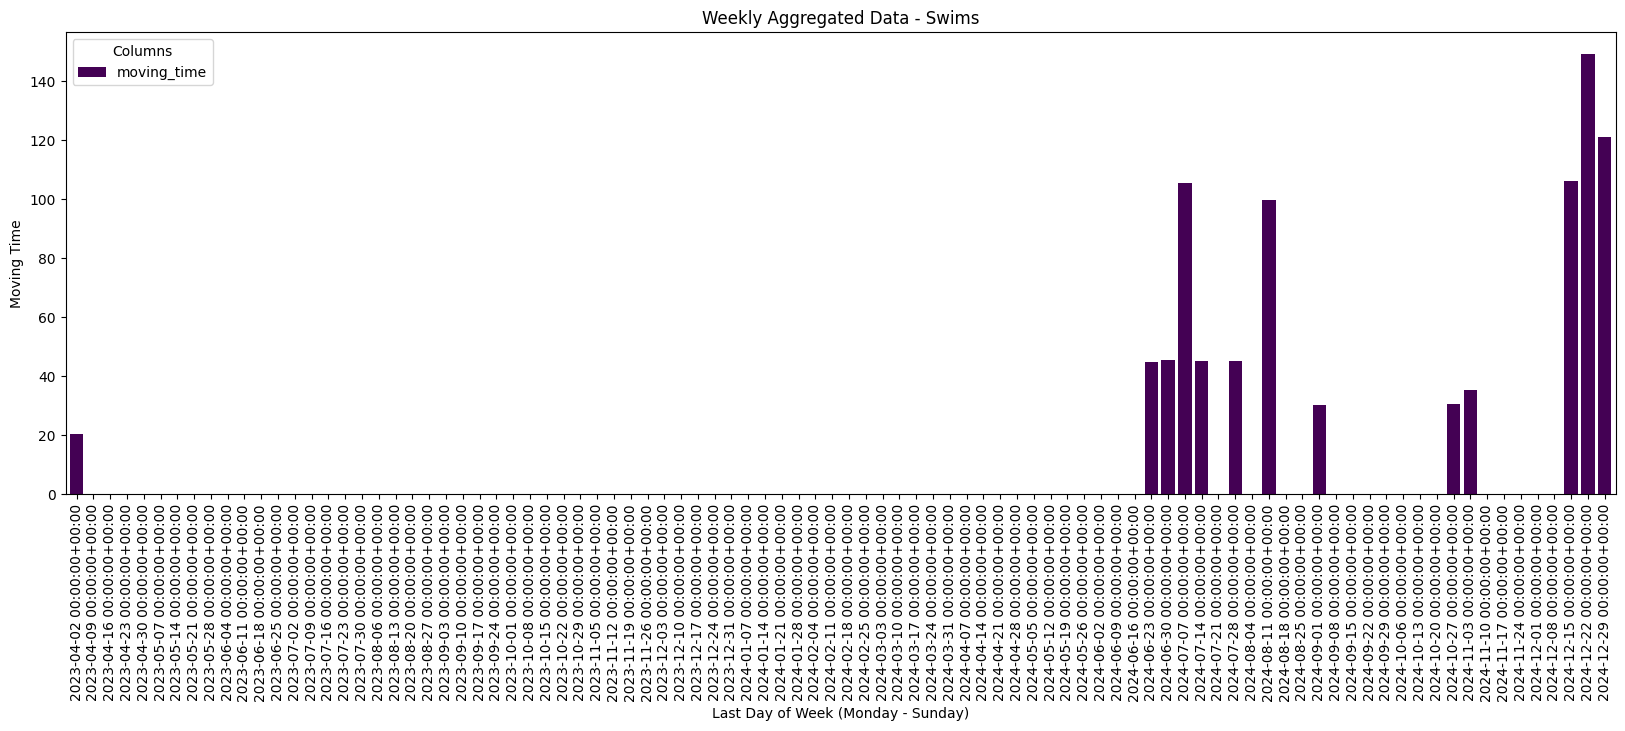

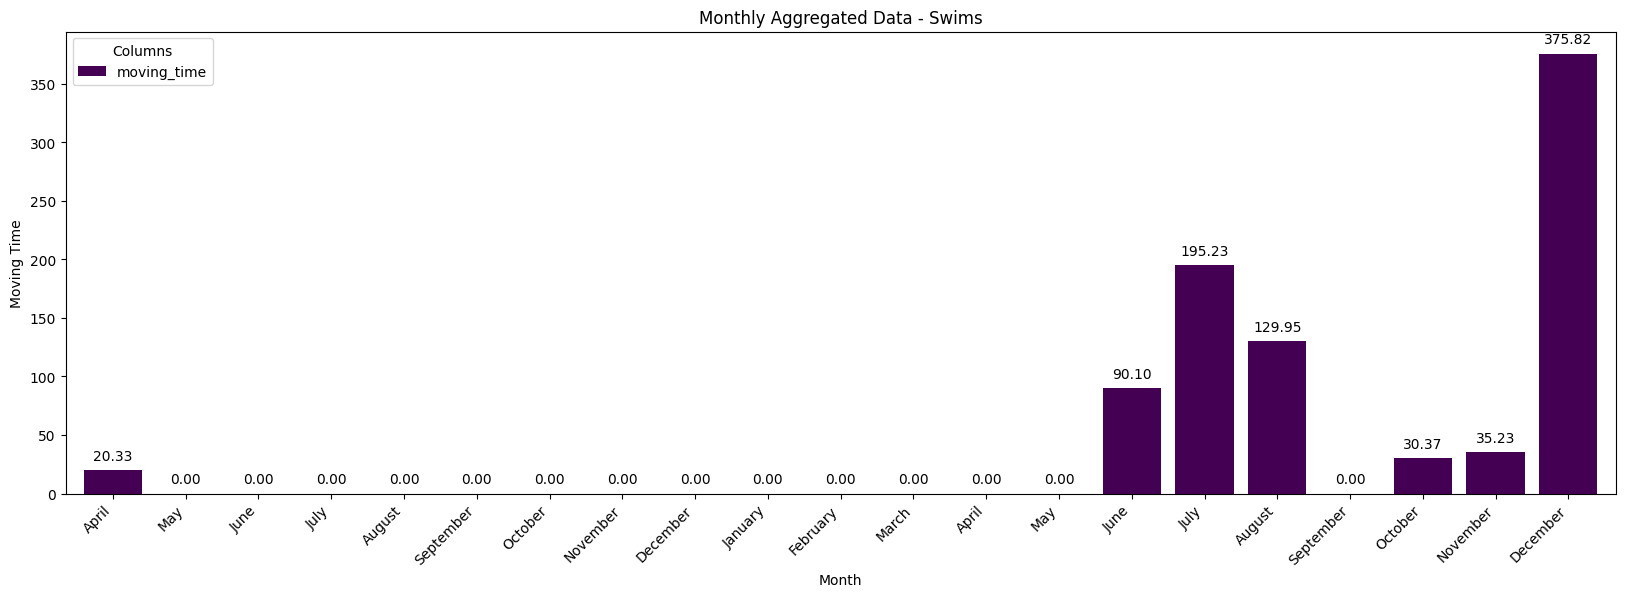

In [17]:
## Biking total by week and month
swims = activities.loc[(activities['type'] == 'Swim')  & (activities['start_date_local'] > '2023-01-01')]  #& (activities['distance'] >= .5) 

# pace vs distance
#sns.set(style="ticks", context="talk")
#sns.regplot(x='distance', y = 'avg_pace', data = runs).set_title("Average Pace vs Distance")

# miles per week
swims_byweek = swims[['moving_time', 'start_date_local']] #['distance', 'avg_pace', 'moving_time', 'start_date_local']
aggregations = {
    # 'distance': 'sum',   # Sum the 'distance' column
    'moving_time': 'sum',   # Sum the 'duration' column
    #'avg_pace': 'mean',     # Average the 'speed' column
}

# Group by week and apply aggregations
swims_byweek = swims_byweek.resample('W-Sun', on='start_date_local').agg(aggregations)

# Display the result
ax = swims_byweek.plot(kind='bar', figsize=(20, 6), width=0.8, colormap='viridis')
plt.title('Weekly Aggregated Data - Swims')
plt.xlabel('Last Day of Week (Monday - Sunday)')
plt.ylabel('Moving Time')
plt.legend(title='Columns')
plt.show()

# miles per month
swims_bymonth = swims[['moving_time', 'start_date_local']] #['distance', 'avg_pace', 'moving_time', 'start_date_local']
aggregations = {
    #'distance': 'sum',   # Sum the 'distance' column
    'moving_time': 'sum',   # Sum the 'duration' column
    #'avg_pace': 'mean',     # Average the 'speed' column
}

# Group by week (Monday to Sunday) and apply aggregations
swims_bymonth = swims_bymonth.resample('M', on='start_date_local').agg(aggregations)

# Display the result
ax = swims_bymonth.plot(kind='bar', figsize=(20, 6), width=0.8, colormap='viridis')
ax.set_xticklabels(swims_bymonth.index.strftime('%B'), rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.title('Monthly Aggregated Data - Swims')
plt.xlabel('Month')
plt.ylabel('Moving Time')
plt.legend(title='Columns')
plt.show()

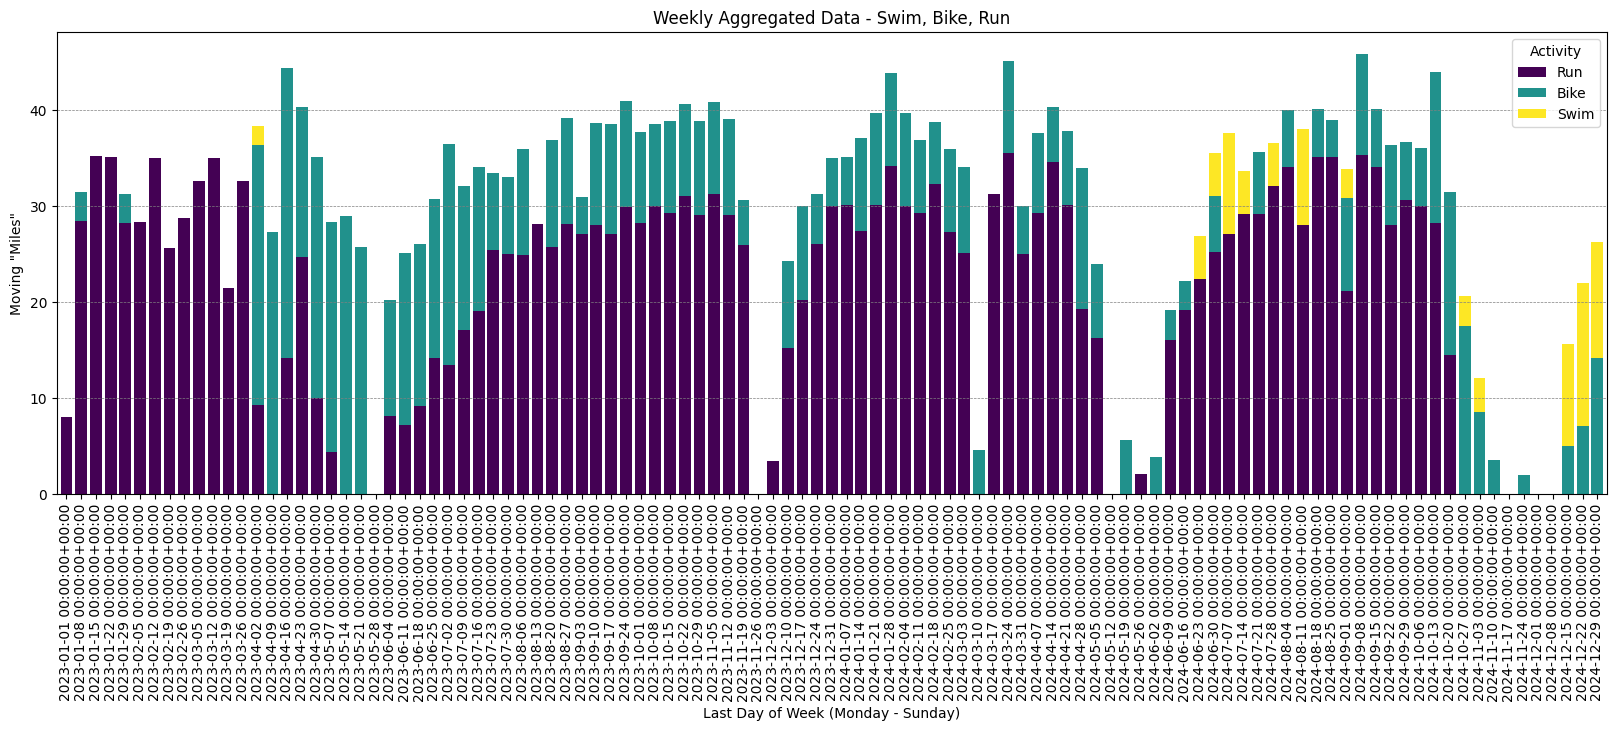

In [29]:
swims_byweek_scale = swims_byweek/10
bikes_byweek_scale = bikes_byweek/10

combined_data = pd.concat([runs_byweek, bikes_byweek_scale, swims_byweek_scale], axis=1)
combined_data.columns = ['Run', 'Bike', 'Swim']

# Plotting all three as grouped bars
ax = combined_data.plot(kind='bar', figsize=(20, 6), width=0.8, colormap='viridis', stacked=True)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.title('Weekly Aggregated Data - Swim, Bike, Run')
plt.xlabel('Last Day of Week (Monday - Sunday)')
plt.ylabel('Moving \"Miles\"')
plt.legend(title='Activity')
plt.show()

In [14]:
## year totals
all_2024 = activities.loc[activities['start_date_local'] >= '2024-01-01']
all_2024['total_elevation_gain'] = all_2024['total_elevation_gain'] * 3.281


total_days = all_2024.groupby('start_date_local').size().sum()
total_time = all_2024['moving_time'].sum()
total_run_miles = all_2024[all_2024['type'] == 'Run']['distance'].sum()
total_elevation = all_2024['total_elevation_gain'].sum()

subset = all_2024.loc[(all_2024['type'] == 'Run') & pd.notna(all_2024['upload_id'])]
longest_run_i = subset['distance'].idxmax()
longest_run_row = all_2024.loc[longest_run_i]
longest_bike_i = all_2024[all_2024['type'] == 'Ride']['distance'].idxmax()
longest_bike_row = all_2024.loc[longest_bike_i]
highest_elevation_i = all_2024['total_elevation_gain'].idxmax()
highest_elevation_row = all_2024.loc[highest_elevation_i]

fastest_run_i = all_2024[all_2024['type'] == 'Run']['avg_pace'].idxmin()
fastest_run_row = all_2024.loc[fastest_run_i]
fastest_bike_i = all_2024[all_2024['type'] == 'Ride']['avg_pace'].idxmax()
fastest_bike_row = all_2024.loc[fastest_bike_i]

print(f'Days Active: {total_days}')
print(f'Total Hours: {total_time/60:.2f}')
print(f'Total Running Miles: {total_run_miles:.2f}')
print(f'Total Elevation: {total_elevation:.2f} ft')
d = longest_run_row['distance']
print(f'Longest Run: {d:.2f} miles')
d = longest_bike_row['distance']
print(f'Longest Bike: {d:.2f} miles')

print("\nLongest Run:")
print(longest_run_row)

print("\nLongest Bike:")
print(longest_bike_row)

print("\nHighest Elevation:")
print(highest_elevation_row)

print("\nFastest Run:")
print(fastest_run_row)

print("\nFastest Bike:")
print(fastest_bike_row)


Days Active: 321
Total Hours: 233.65
Total Running Miles: 1043.90
Total Elevation: 41396.05 ft
Longest Run: 10.15 miles
Longest Bike: 15.83 miles

Longest Run:
name                                Afternoon Run
upload_id                           13468382073.0
type                                          Run
distance                                10.152704
moving_time                             88.633333
average_speed                               3.072
max_speed                                   4.568
total_elevation_gain                     672.2769
start_date_local        2024-10-11 16:10:25+00:00
start_time                               16:10:25
avg_pace                                  8.73125
Name: 36, dtype: object

Longest Bike:
name                               Afternoon Ride
upload_id                           13373957415.0
type                                         Ride
distance                                15.825668
moving_time                             60.466667
a

C:\Users\kylie\AppData\Local\Temp\ipykernel_49580\2400027121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_2024['total_elevation_gain'] = all_2024['total_elevation_gain'] * 3.281


Create a map of activites (red = bike, blue = run, purple = walk)



In [15]:
import os
import requests
import urllib3
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import folium
import polyline
import base64
from tqdm import tqdm

activities_map = pd.json_normalize(all_activities)
activities_map['start_date_local'] = pd.to_datetime(activities_map['start_date_local'], errors='coerce')
# activities_map['start_date_local'] = activities_map['start_date_local'].dt.date

activities_map = activities_map.loc[activities_map['start_date_local'] > '2023-01-01']

# cols = ['id', 'type', 'map.summary_polyline']
# activities_map = activities_map[cols]

activities_map['map.polyline'] = activities_map['map.summary_polyline'].apply(polyline.decode)
activities_map = activities_map[~activities_map['map.polyline'].apply(lambda x: len(x) == 0)]

# define function to get elevation data using the open-elevation API
def get_elevation(latitude, longitude):
    base_url = 'https://api.open-elevation.com/api/v1/lookup'
    payload = {'locations': f'{latitude},{longitude}'}
    r = requests.get(base_url, params=payload).json()['results'][0]
    return r['elevation']
# get elevation data
# elevation_data = list()
# for idx in tqdm(activities_map.index):
#     activity = activities_map.loc[idx, :]
#     elevation = [get_elevation(coord[0], coord[1]) for coord in activity['map.polyline']]
#     elevation_data.append(elevation)
# # add elevation data to dataframe
# activities_map['map.elevation'] = elevation_data

# convert data types
# activities_map.loc[:, 'start_date'] = pd.to_datetime(activities_map['start_date']).dt.tz_localize(None)
# activities_map.loc[:, 'start_date_local'] = pd.to_datetime(activities_map['start_date_local']).dt.tz_localize(None)
# convert values
activities_map.loc[:, 'distance'] /= 1000 # convert from m to km
activities_map.loc[:, 'average_speed'] *= 3.6 # convert from m/s to km/h
activities_map.loc[:, 'max_speed'] *= 3.6 # convert from m/s to km/h
# set index
activities_map.set_index('start_date_local', inplace=True)
# drop columns
activities_map.drop(
    [
        'map.summary_polyline', 
        'resource_state',
        'external_id', 
        'upload_id', 
        'location_city', 
        'location_state', 
        'has_kudoed', 
        #'start_date', 
        'athlete.resource_state', 
        'utc_offset', 
        'map.resource_state', 
        'athlete.id', 
        'visibility', 
        'heartrate_opt_out', 
        'upload_id_str', 
        'from_accepted_tag', 
        'map.id', 
        'manual', 
        'private', 
        'flagged', 
    ], 
    axis=1, 
    inplace=True
)

# select one activity
# my_ride = activities_map.iloc[1, :] # first activity (most recent)

# print(my_ride['map.polyline'])
# # plot ride on map
# centroid = [
#     np.mean([coord[0] for coord in my_ride['map.polyline']]), 
#     np.mean([coord[1] for coord in my_ride['map.polyline']])
# ]
# m = folium.Map(location=centroid, zoom_start=10)
# folium.PolyLine(my_ride['map.polyline'], color='red').add_to(m)
# display(m)

# color scheme
color = {'Ride':'red', 'Run':'blue', 'Walk':'purple'}
# plot all activities on map
resolution, width, height = 75, 6, 6.5
def centroid(polylines):
    x, y = [], []
    for polyline in polylines:
        for coord in polyline:
            x.append(coord[0])
            y.append(coord[1])
    return [(min(x)+max(x))/2, (min(y)+max(y))/2]
m = folium.Map(location=centroid(activities_map['map.polyline']), zoom_start=4)
for row in activities_map.iterrows():
    row_index = row[0]
    row_values = row[1]
    folium.PolyLine(row_values['map.polyline'], color=color[row_values['type']], opacity=0.4).add_to(m)
    
    halfway_coord = row_values['map.polyline'][int(len(row_values['map.polyline'])/2)]
# popup text
    # html = """
    # <h3>{}</h3>
    #     <p>
    #         <code>
    #         Date : {} <br>
    #         Time : {}
    #         </code>
    #     </p>
    # <h4>{}</h4>
    #     <p> 
    #         <code>
    #             Distance&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp: {:.2f} km <br>
    #             Elevation Gain&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp: {:.0f} m <br>
    #             Moving Time&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp: {} <br>
    #             Average Speed&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp: {:.2f} km/h (maximum: {:.2f} km/h) <br>
    #             Average Cadence&nbsp;&nbsp;&nbsp;&nbsp;&nbsp: {:.1f} rpm <br>
    #             Average Heart Rate&nbsp;&nbsp: {:.0f} bpm (maximum: {:.0f} bpm) <br>
    #             Average Watts&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp: {:.1f} W <br>
    #             Average Temperature&nbsp: {:.1f} <br>
    #             Kilojoules&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp: {:.1f} <br>
    #             Relative Effort&nbsp;&nbsp;&nbsp;&nbsp;&nbsp: {:.0f} <br>
    #             Athletes&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp: {:.0f} <br>
    #             Kudos&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp: {:.0f} <br>
                
    #         </code>
    #     </p>
    # <img src="data:image/png;base64,{}">
    # """.format(
    #     row_values['name'], 
    #     row_index.date(), 
    #     row_index.time(),  
    #     row_values['type'], 
    #     row_values['distance'], 
    #     row_values['total_elevation_gain'], 
    #     time.strftime('%H:%M:%S', time.gmtime(row_values['moving_time'])), 
    #     row_values['average_speed'], row_values['max_speed'], 
    #     row_values['average_cadence'],  
    #     row_values['average_heartrate'], row_values['max_heartrate'], 
    #     #row_values['average_watts'], 
    #     #row_values['average_temp'], 
    #     #row_values['kilojoules'], 
    #     #row_values['suffer_score'], 
    #     #row_values['athlete_count'], 
    #     #row_values['kudos_count'], 
    #     # elevation_profile[row_values['id']], 
    # )
    
    # # add marker to map
    # iframe = folium.IFrame(html, width=(width*resolution)+20, height=(height*resolution)+20)
    # popup = folium.Popup(iframe, max_width=2650)
    # icon = folium.Icon(color=color[row_values['type']], icon='info-sign')
    # marker = folium.Marker(location=halfway_coord, popup=popup, icon=icon)
    # marker.add_to(m)
m.save('mymap.html')
display(m)